### Value at Risk

### Parametric Method:

#### Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
import pandas_datareader.data as web


#### Set time from to a certain number of years: 


In [2]:
years = 15 

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365 * years)

#### The tickers:

In [3]:
tickers = ['NVDA', 'AMZN', 'GLD', 'GOOGL', 'ORCL']

#### Downloading the daily adjusted closed prices: 

Adjusted closed prices account for dividend and stock splits to make analysis more accurate. 

Here stooq is good for development and testing and stuff but yfinance is a bit more accurate, for final results try to use yfinance

In [4]:
adj_close_df = web.DataReader(
    tickers,
    "stooq",
    startDate,
    endDate
)["Close"]

adj_close_df = adj_close_df.sort_index()
print(adj_close_df)


Symbols           NVDA      AMZN     GLD     GOOGL      ORCL
Date                                                        
2011-01-10    0.472964    9.2340  134.12   15.2996   26.2669
2011-01-11    0.465675    9.2170  134.91   15.3443   26.2213
2011-01-12    0.535382    9.2040  135.46   15.3663   26.1867
2011-01-13    0.536329    9.2765  134.05   15.3618   26.3838
2011-01-14    0.540914    9.4375  132.69   15.5481   26.4432
...                ...       ...     ...       ...       ...
2025-12-26  190.530000  232.5200  416.74  313.5100  197.9900
2025-12-29  188.220000  232.0700  398.60  313.5600  195.3800
2025-12-30  187.540000  232.5300  398.89  313.8500  197.2100
2025-12-31  186.500000  230.8200  396.31  313.0000  194.9100
2026-01-02  188.850000  226.5000  398.28  315.1500  195.7100

[3768 rows x 5 columns]


#### Calculate the daily log returns and drop NAs:

In [5]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

Symbols         NVDA      AMZN       GLD     GOOGL      ORCL
Date                                                        
2011-01-11 -0.015531 -0.001843  0.005873  0.002917 -0.001738
2011-01-12  0.139493 -0.001411  0.004069  0.001433 -0.001320
2011-01-13  0.001767  0.007846 -0.010464 -0.000293  0.007499
2011-01-14  0.008513  0.017207 -0.010197  0.012055  0.002249
2011-01-18 -0.023687  0.013158  0.005561  0.024467  0.008986
...              ...       ...       ...       ...       ...
2025-12-26  0.010128  0.000602  0.011609 -0.001848  0.002529
2025-12-29 -0.012198 -0.001937 -0.044504  0.000159 -0.013270
2025-12-30 -0.003619  0.001980  0.000727  0.000924  0.009323
2025-12-31 -0.005561 -0.007381 -0.006489 -0.002712 -0.011731
2026-01-02  0.012522 -0.018893  0.004959  0.006846  0.004096

[3765 rows x 5 columns]


#### Create an equally weighted portfolio:

In [7]:
portfolio_value = 1000 

weights = np.array([1/len(tickers)] * len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


#### Create the historical portfolio returns:

In [8]:
historical_returns = (log_returns * weights).sum(axis = 1)
print(historical_returns)

Date
2011-01-11   -0.002064
2011-01-12    0.028452
2011-01-13    0.001271
2011-01-14    0.005965
2011-01-18    0.005697
                ...   
2025-12-26    0.004604
2025-12-29   -0.014350
2025-12-30    0.001867
2025-12-31   -0.006775
2026-01-02    0.001906
Length: 3765, dtype: float64


#### Find X-day historical returns:

In [9]:
days = 5 

historical_x_day_return = historical_returns.rolling(window= days).sum()


#### Create a covariance matrix for all the securities:  

This gives us a daily covariance matrix, so we annualize it by multiplying by 252 since there is 252 trading days in a year

In [10]:
cov_matrix = log_returns.cov() * 252 

#### Calculate Portfolio std deviation:

In [11]:
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

#### Set difference confidence levels to visualize: 

In [12]:
confidence_levels = [0.9, 0.95, 0.99] 

#### Calculate VaR at different confidence levels:

In [15]:
VaRs = [] 

for cl in confidence_levels: 
    VaR = portfolio_value * portfolio_std_dev * norm.ppf(cl) * np.sqrt(days/252)
    VaRs.append(VaR)



#### Print out VaR results:

In [17]:
print(f'{"Confidence level":<20} {"Value at Risk":<20}' ) 

print('-' * 40)

## Print for each confidence level its corresponding VaR value

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence level     Value at Risk       
----------------------------------------
    90%:          $     38.70
    95%:          $     49.68
    99%:          $     70.26


#### Plot:

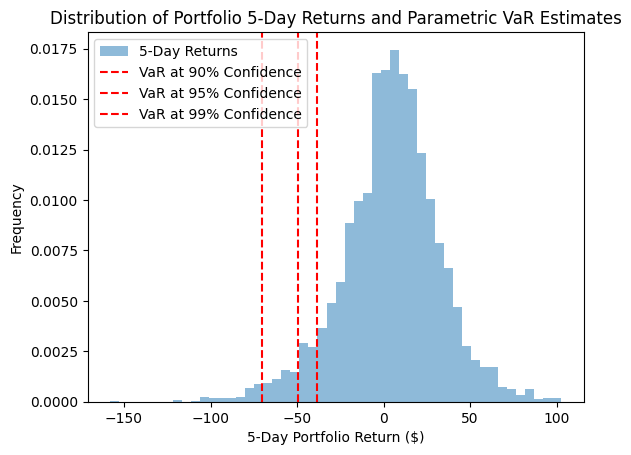

In [19]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_return * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()